<a href="https://colab.research.google.com/github/tinarobfar/eccdum_assignments/blob/main/6_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 8.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import os
import io
import requests
from PIL import Image
from tempfile import TemporaryDirectory

from eccd_datasets import load_images

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
product_prices = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


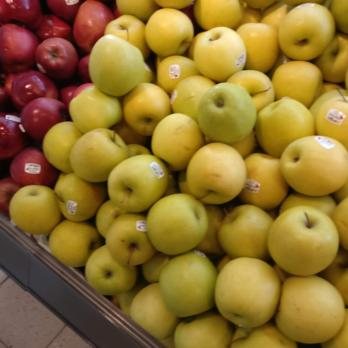

In [4]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

image = load_image_data(df_images.iloc[0]["image_data"])
image

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Custom dataset that emulates ImageFolder but from df_images
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = sorted(df['coarse_cat'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_data = self.df.iloc[idx]["image_data"]
        image = Image.open(io.BytesIO(image_data))
        label_name = self.df.iloc[idx]["coarse_cat"]
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)
        return image, label

# Split the dataframe into training and validation sets
train_df = df_images[df_images['dataset'] == 'train']
val_df = df_images[df_images['dataset'] == 'val']
test_df = df_images[df_images['dataset'] == 'test']

# Create training and validation datasets
image_datasets = {
    'train': CustomImageDataset(train_df, transform=data_transforms['train']),
    'val': CustomImageDataset(val_df, transform=data_transforms['val']),
    'test': CustomImageDataset(test_df, transform=data_transforms['test'])
}

# Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=4, shuffle=False, num_workers=4)
}

# Calculate the size of each dataset and get the classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


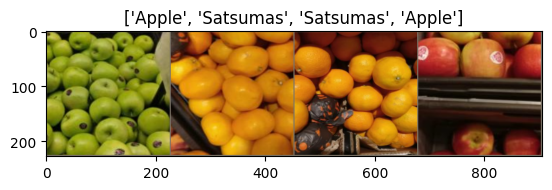

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features

print(f"Number of input features in last layer: {input_last_layer}")
print(f"Number of output features in last layer: {output_last_layer}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


Number of input features in last layer: 512
Number of output features in last layer: 1000


In [11]:
number_of_classes = df_images['coarse_cat'].nunique()
print(f"Number of classes: {number_of_classes}")

model_ft.fc = nn.Linear(in_features=input_last_layer, out_features=number_of_classes)

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f"Number of input features in last layer: {input_last_layer}")
print(f"Number of output features in last layer: {output_last_layer}")

Number of classes: 5
Number of input features in last layer: 512
Number of output features in last layer: 5


In [12]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9303 Acc: 0.6385
test Loss: 0.3722 Acc: 0.8321

Epoch 1/24
----------
train Loss: 0.6548 Acc: 0.7689
test Loss: 0.4144 Acc: 0.8593

Epoch 2/24
----------
train Loss: 0.6479 Acc: 0.7911
test Loss: 0.7185 Acc: 0.7821

Epoch 3/24
----------
train Loss: 0.5402 Acc: 0.8252
test Loss: 0.5846 Acc: 0.8124

Epoch 4/24
----------
train Loss: 0.5334 Acc: 0.8148
test Loss: 0.3954 Acc: 0.8517

Epoch 5/24
----------
train Loss: 0.4722 Acc: 0.8237
test Loss: 0.6232 Acc: 0.8351

Epoch 6/24
----------
train Loss: 0.4275 Acc: 0.8489
test Loss: 0.7482 Acc: 0.8245

Epoch 7/24
----------
train Loss: 0.2404 Acc: 0.9141
test Loss: 0.3625 Acc: 0.8684

Epoch 8/24
----------
train Loss: 0.1986 Acc: 0.9289
test Loss: 0.4449 Acc: 0.8669

Epoch 9/24
----------
train Loss: 0.2735 Acc: 0.9096
test Loss: 0.4663 Acc: 0.8654

Epoch 10/24
----------
train Loss: 0.2233 Acc: 0.9200
test Loss: 0.4691 Acc: 0.8638

Epoch 11/24
----------
train Loss: 0.1736 Acc: 0.9422
test Loss: 0.5016 Acc

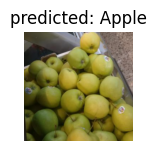

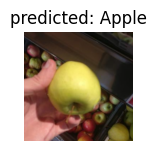

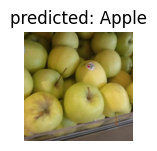

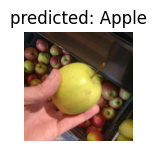

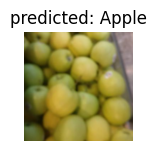

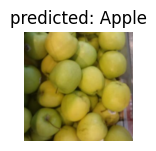

In [14]:
visualize_model(model_ft)

In [15]:
def visualize_model_predictions(model, df_images, idx=0):
    was_training = model.training
    model.eval()

    # Select the image from the DataFrame
    image_data = df_images.iloc[idx]["image_data"]  # Use the image index
    img = Image.open(io.BytesIO(image_data))  # Load the image from the binary data
    img = data_transforms['val'](img)  # Apply the validation transformation
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move image to the device (GPU/CPU)

    with torch.no_grad():
        outputs = model(img)  # Perform the prediction
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        # Create the visualization
        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])  # Display the image

        model.train(mode=was_training)  # Restore the model to training mode


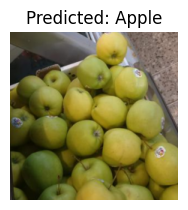

In [16]:
visualize_model_predictions(model_ft, val_df, idx=0)

plt.ioff()
plt.show()

In [17]:
# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    accuracy = accuracy_score(actuals, predictions)
    return accuracy, predictions, actuals

# Evaluate the model on the validation dataset
accuracy, preds, labels = evaluate_model(model_ft, dataloaders['val'])
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 92.98%


In [18]:
def calculate_cost(predictions, actuals, prices):
    total_cost = 0
    for pred, actual in zip(predictions, actuals):
        # Get the corresponding labels
        pred_label = class_names[pred]
        actual_label = class_names[actual]

        # Get the price for each class
        pred_price = prices.get(pred_label, 0)  # Default to 0 if the key doesn't exist
        actual_price = prices.get(actual_label, 0)  # Same for the actual label

        # Check if the price is missing
        if pred_price == 0 or actual_price == 0:
            print(f"Warning: Missing price for {pred_label} or {actual_label}. Using 0.")

        # Print for all cases
        if pred != actual:
          if pred > actual:
            print("The customer paid too much.")
            print(f"Predicted Label: {pred_label} (Price: ${pred_price})")
            print(f"Actual Label: {actual_label} (Price: ${actual_price})")
          else:
            print("The customer paid too little.")
            print(f"Predicted Label: {pred_label} (Price: ${pred_price})")
            print(f"Actual Label: {actual_label} (Price: ${actual_price})")

        # Calculate the cost only in the case of misclassification
        if pred != actual:  # Only if the prediction is incorrect
            if pred > actual:  # The customer paid too much
                total_cost += 5 * (pred_price - actual_price)  # Penalty
            else:  # The customer paid too little
                total_cost += (actual_price - pred_price)

    return total_cost

model_ft.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Calculate the total cost based on predictions in the validation set
total_cost = calculate_cost(val_preds, val_labels, product_prices)
print(f'Total Cost for Misclassifications: ${total_cost:.2f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


The customer paid too much.
Predicted Label: Pear (Price: $89)
Actual Label: Apple (Price: $74)
The customer paid too much.
Predicted Label: Pear (Price: $89)
Actual Label: Melon (Price: $109)
The customer paid too little.
Predicted Label: Apple (Price: $74)
Actual Label: Melon (Price: $109)
The customer paid too much.
Predicted Label: Satsumas (Price: $44)
Actual Label: Orange (Price: $35)
Total Cost for Misclassifications: $55.00


In [19]:
for pred, actual in zip(val_preds, val_labels):
    if pred != actual:
        print(f"Misclassification: Predicted {pred} (label {class_names[pred]}), Actual {actual} (label {class_names[actual]})")

Misclassification: Predicted 3 (label Pear), Actual 0 (label Apple)
Misclassification: Predicted 3 (label Pear), Actual 1 (label Melon)
Misclassification: Predicted 0 (label Apple), Actual 1 (label Melon)
Misclassification: Predicted 4 (label Satsumas), Actual 2 (label Orange)
